# Training Notebook

This notebook contains examples and results for the models

In [6]:
"""
Imports and definitions
"""

import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
import pickle
import scipy
import xlrd
import tensorflow.keras.backend as K
import hiddenlayer as hl

import os

tf.enable_eager_execution()

# Data folders location
tid_loc = "../tid2013"
hdai_loc = "../HD_images"
live_loc = "../databaserelease2/databaserelease2"
csiq_loc = "../CSIQ"

In [7]:
import importlib
import utils
import models

importlib.reload(utils)
importlib.reload(models)

<module 'models' from 'E:\\Data\\Vivien\\epfl\\MA3\\SemesterProject\\package\\models.py'>

## Preparing reference images and global data

In [9]:
scores_tid = utils.read_scores("{0}/mos.txt".format(tid_loc)).astype(np.float32)
ref_images_tid = utils.read_images("{0}/reference_images".format(tid_loc))
ref_images_tid = ref_images_tid.astype(np.float32)

refs_live = scipy.io.loadmat("{0}/refnames_all.mat".format(live_loc))
dmos_live = scipy.io.loadmat("{0}/dmos.mat".format(live_loc))
nimages_live = 779
non_orgs_scores_live = dmos_live["dmos"][0][np.where(dmos_live["orgs"][0] == 0)]

scores_hdai = utils.read_scores_hdai(hdai_loc).astype(np.float32)
scores_csiq = xlrd.open_workbook("{0}/csiq.DMOS.xlsx".format(csiq_loc)).sheet_by_index(5).col_values(8, 4)
scores_csiq = np.array(scores_csiq)
scores_hdxl = utils.read_scores_hdxl(hdai_loc).astype(np.float32)

def key_fun(x):
    splitted = x.split("_")
    return 10000 * int(splitted[0][1:]) + 100 * int(splitted[1]) + int(splitted[2][:-4])
image_names_tid = sorted(os.listdir("{0}/distorted_images".format(tid_loc)), key=key_fun)

In [10]:
def evaluate_metrics_on_generators(model, names, generators, steps, scores):
    results_list = []
    for value in zip(names, generators, steps, scores):
        print(value[0])
        results = model.predict_generator(value[1], value[2]).flatten()
        print(stats.spearmanr(results, value[3]))
        print(stats.pearsonr(results, value[3]))
        results_list.append(results)
    return results_list

def evaluate_correlation_metrics(model, patch_size=32):
    names = ["TID2013:", "LIVE:", "HD_AI:", "CSIQ:", "HD_XL:"]
    test_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, False, n_patches=128, patch_size=patch_size)
    test_gen_live = utils.live_batch_generator(live_loc, np.array(range(29)), dmos_live["dmos"][0].flatten(),
                                               dmos_live["orgs"][0].flatten(), n_p=128, patch_size=patch_size)
    test_gen_hdai = utils.hdai_batch_generator(hdai_loc, endless=False, n_patches=256, patch_size=patch_size)
    test_gen_csiq = utils.csiq_batch_generator(csiq_loc, endless=False, n_patches=128, patch_size=patch_size, batch_size=2)
    test_gen_hdxl = utils.hdxl_batch_generator(hdai_loc, endless=False, n_patches=256, patch_size=patch_size, batch_size=2)
    generators = [test_gen, test_gen_live, test_gen_hdai, test_gen_csiq, test_gen_hdxl]
    steps = [25*12, nimages_live, len(scores_hdai), 433, 152]
    scores = [scores_tid, non_orgs_scores_live, scores_hdai, scores_csiq, scores_hdxl]
    return evaluate_metrics_on_generators(model, names, generators, steps, scores)

def evaluate_correlation_metrics_ms(model):
    names = ["TID2013:", "LIVE:", "HD_AI:", "CSIQ:", "HD_XL:"]
    test_gen = utils.tid_batch_generator_ms(tid_loc, ref_images_tid, scores_tid, image_names_tid, False, n_patches=128)
    test_gen_live = utils.live_batch_generator_ms(live_loc, np.array(range(29)), dmos_live["dmos"][0].flatten(),
                                               dmos_live["orgs"][0].flatten(), n_p=128)
    test_gen_hdai = utils.hdai_batch_generator_ms(hdai_loc, endless=False, n_patches=256)
    test_gen_csiq = utils.csiq_batch_generator_ms(csiq_loc, endless=False, n_patches=128, batch_size=2)
    test_gen_hdxl = utils.hdxl_batch_generator_ms(hdai_loc, endless=False, n_patches=256, batch_size=2)
    generators = [test_gen, test_gen_live, test_gen_hdai, test_gen_csiq, test_gen_hdxl]
    steps = [25*12, nimages_live, len(scores_hdai), 433, 152]
    scores = [scores_tid, non_orgs_scores_live, scores_hdai, scores_csiq, scores_hdxl]
    return evaluate_metrics_on_generators(model, names, generators, steps, scores)

## Training Metrics

### WADIQAM - NO SIGMOID

In [ ]:
wdqm_model_ns = models.get_wadiqam_model(is_diqam=False, lr=0.000025, use_sigmoid=False)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [ ]:
hist_wdqm_ns = utils.train_on_generators("wadiqam_ns", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_ns)

In [ ]:
utils.plot_history("wadiqam_ns/history.pkl", validation_freq=1)

In [ ]:
wdqm_model_ns.load_weights("wadiqam_ns/best_model.hdf5")
im_scores_bm_ns = evaluate_correlation_metrics(wdqm_model_ns)

### DIQAM - MAE

In [236]:
dqm_model_mae = models.get_wadiqam_model(is_diqam=True, lr=0.00005)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [13]:
hist_dqm_mae = utils.train_on_generators("diqam_mae", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=dqm_model_mae)

Dir created
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 150s 499ms/step - loss: 1.0652 - val_loss: 2.1482
Epoch 2/100
300/300 [==============================] - 147s 491ms/step - loss: 0.8263 - val_loss: 1.6196
Epoch 3/100
300/300 [==============================] - 147s 490ms/step - loss: 0.7186 - val_loss: 1.4770
Epoch 4/100
300/300 [==============================] - 147s 489ms/step - loss: 0.7269 - val_loss: 1.5592
Epoch 5/100
300/300 [==============================] - 147s 489ms/step - loss: 0.6392 - val_loss: 1.5529
Epoch 6/100
300/300 [==============================] - 147s 489ms/step - loss: 0.6210 - val_loss: 1.9951
Epoch 7/100
300/300 [==============================] - 142s 472ms/step - loss: 0.6263 - val_loss: 1.4373
Epoch 8/100
300/300 [==============================] - 143s 475ms/step - loss: 0.6077 - val_loss: 1.4695
Epoch 9/100
300/300 [==============================] - 143s 476ms/step -

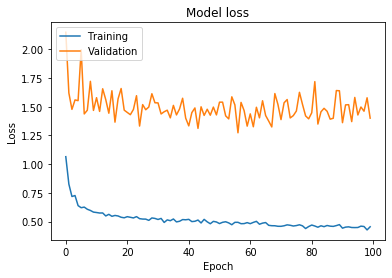

In [38]:
utils.plot_history("diqam_mae/history.pkl", validation_freq=1)

In [237]:
dqm_model_mae.load_weights("diqam_mae/model.hdf5")
im_scores = evaluate_correlation_metrics(dqm_model_mae)

TID2013:
SpearmanrResult(correlation=0.9307635422147478, pvalue=0.0)
(0.92933625, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8984176790239536, pvalue=6.412464801236772e-280)
(-0.8933347243305928, 3.937661761302353e-272)
HD_AI:
SpearmanrResult(correlation=0.7521611303653176, pvalue=9.892555254789152e-50)
(0.77250874, 5.429207019686605e-54)
CSIQ:
SpearmanrResult(correlation=-0.9384339677181365, pvalue=0.0)
(-0.9257108854057645, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8219338693881331, pvalue=8.399634585713407e-76)
(0.8064035, 7.1582484369258826e-71)


In [238]:
dqm_model_mae.load_weights("diqam_mae/best_model.hdf5")
im_scores = evaluate_correlation_metrics(dqm_model_mae)

TID2013:
SpearmanrResult(correlation=0.9098388484486057, pvalue=0.0)
(0.91298705, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8889088270481593, pvalue=1.1536198398094752e-265)
(-0.88044137452264, 5.03320153646742e-254)
HD_AI:
SpearmanrResult(correlation=0.8093720677553604, pvalue=5.754749385588952e-63)
(0.83161455, 2.1696006098776428e-69)
CSIQ:
SpearmanrResult(correlation=-0.9325808361330433, pvalue=0.0)
(-0.921030083158251, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8209707815753975, pvalue=1.7531615118513228e-75)
(0.8064274, 7.039874060229852e-71)


### WADIQAM - MAE

In [11]:
wdqm_model_mae = models.get_wadiqam_model(is_diqam=False, lr=0.000025)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [37]:
hist_wdqm_mae = utils.train_on_generators("wadiqam_mae", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mae)

Dir exists
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 151s 502ms/step - loss: 1.1144 - val_loss: 2.2030
Epoch 2/100
300/300 [==============================] - 146s 487ms/step - loss: 0.9679 - val_loss: 2.0357
Epoch 3/100
300/300 [==============================] - 148s 493ms/step - loss: 0.8610 - val_loss: 1.9143
Epoch 4/100
300/300 [==============================] - 148s 492ms/step - loss: 0.7996 - val_loss: 1.8320
Epoch 5/100
300/300 [==============================] - 139s 464ms/step - loss: 0.7328 - val_loss: 1.7550
Epoch 6/100
300/300 [==============================] - 139s 464ms/step - loss: 0.7214 - val_loss: 1.7643
Epoch 7/100
300/300 [==============================] - 139s 464ms/step - loss: 0.6811 - val_loss: 1.7438
Epoch 8/100
300/300 [==============================] - 139s 464ms/step - loss: 0.6377 - val_loss: 1.6872
Epoch 9/100
300/300 [==============================] - 137s 457ms/step - 

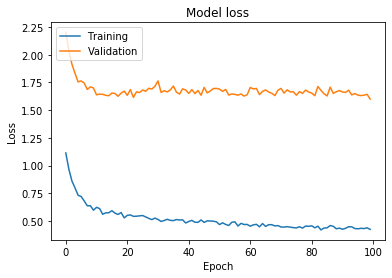

In [39]:
utils.plot_history("wadiqam_mae/history.pkl", validation_freq=1)

In [65]:
wdqm_model_mae.load_weights("wadiqam_mae/model.hdf5")
im_scores_m_wdqm = evaluate_correlation_metrics(wdqm_model_mae)

TID2013:
SpearmanrResult(correlation=0.9351773480688355, pvalue=0.0)
(0.94021773, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8961143097063186, pvalue=2.4341941355088005e-276)
(-0.8892617865059129, 3.601580211853657e-266)
HD_AI:
SpearmanrResult(correlation=0.78452847845413, pvalue=1.0084809749905066e-56)
(0.80946386, 5.435948057049359e-63)
CSIQ:
SpearmanrResult(correlation=-0.9112316867873665, pvalue=0.0)
(-0.8987857525692315, 1.1111985117123e-311)
HD_XL:
SpearmanrResult(correlation=0.8514061117004552, pvalue=1.2468048335968435e-86)
(0.82480335, 9.132275454702831e-77)


In [17]:
wdqm_model_mae.load_weights("wadiqam_mae/best_model.hdf5")
im_scores_bm_wdqm = evaluate_correlation_metrics(wdqm_model_mae)

TID2013:
SpearmanrResult(correlation=0.9392498663624926, pvalue=0.0)
(0.9422699, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8969355001252728, pvalue=1.318256226544395e-277)
(-0.890736631562589, 2.662135678433005e-268)
HD_AI:
SpearmanrResult(correlation=0.8205331888969593, pvalue=4.445949135069597e-66)
(0.83545595, 1.3537859093913704e-70)
CSIQ:
SpearmanrResult(correlation=-0.9172891882480928, pvalue=0.0)
(-0.9016141957746001, 1.0141845e-316)
HD_XL:
SpearmanrResult(correlation=0.8382557971545741, pvalue=1.5704820298627884e-81)
(0.81145567, 2.0007579639673572e-72)


In [18]:
wdqm_model_mae.load_weights("wadiqam_mae/best_model.hdf5")
im_scores_bm_wdqm = evaluate_correlation_metrics(wdqm_model_mae)

TID2013:
SpearmanrResult(correlation=0.9323091686288366, pvalue=0.0)
(0.93631077, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8949227332161751, pvalue=1.6036961464477928e-274)
(-0.8878497566387401, 3.705375346337315e-264)
HD_AI:
SpearmanrResult(correlation=0.8018578068045724, pvalue=5.518170320116822e-61)
(0.82771116, 3.3872019161592075e-68)
CSIQ:
SpearmanrResult(correlation=-0.9195814786242575, pvalue=0.0)
(-0.9048570570536714, 1.1e-322)
HD_XL:
SpearmanrResult(correlation=0.8576675345656487, pvalue=3.0960827805916696e-89)
(0.82720083, 1.3862058077352047e-77)


In [19]:
wdqm_model_mae.load_weights("wadiqam_mae/best_model.hdf5")
im_scores_bm_wdqm = evaluate_correlation_metrics(wdqm_model_mae)

TID2013:
SpearmanrResult(correlation=0.9306823266591058, pvalue=0.0)
(0.936394, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8971974687535142, pvalue=5.173288812708017e-278)
(-0.8905559903140731, 4.874290898060176e-268)
HD_AI:
SpearmanrResult(correlation=0.8024615884234336, pvalue=3.852338247447157e-61)
(0.8259582, 1.1378218237278575e-67)
CSIQ:
SpearmanrResult(correlation=-0.919518380149253, pvalue=0.0)
(-0.907012748539718, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8501854856470378, pvalue=3.88741122238086e-86)
(0.82387656, 1.878210778934519e-76)


### WADIQAM - MAE NO DROP

In [24]:
wdqm_model_mae_nodrop = models.get_wadiqam_model(is_diqam=False, lr=0.000025, drop_rate=0.001)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [25]:
hist_wdqm_mae_nodrop = utils.train_on_generators("wadiqam_mae_nodrop", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mae_nodrop)

Dir created
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 178s 593ms/step - loss: 1.1387 - val_loss: 2.1404
Epoch 2/100
300/300 [==============================] - 178s 592ms/step - loss: 0.9756 - val_loss: 2.0219
Epoch 3/100
300/300 [==============================] - 179s 595ms/step - loss: 0.8720 - val_loss: 1.9364
Epoch 4/100
300/300 [==============================] - 178s 593ms/step - loss: 0.7546 - val_loss: 1.8179
Epoch 5/100
300/300 [==============================] - 179s 598ms/step - loss: 0.6858 - val_loss: 1.7946
Epoch 6/100
300/300 [==============================] - 241s 804ms/step - loss: 0.6728 - val_loss: 1.7372
Epoch 7/100
300/300 [==============================] - 258s 860ms/step - loss: 0.6227 - val_loss: 1.7323
Epoch 8/100
300/300 [==============================] - 251s 838ms/step - loss: 0.6028 - val_loss: 1.7334
Epoch 9/100
300/300 [==============================] - 251s 837ms/step -

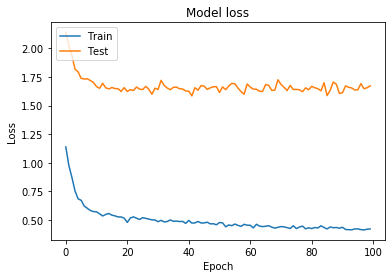

In [26]:
utils.plot_history(hist_wdqm_mae_nodrop[1], validation_freq=1)

In [28]:
wdqm_model_mae_nodrop.load_weights("wadiqam_mae_nodrop/model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_mae_nodrop)

TID2013:
SpearmanrResult(correlation=0.936053239629361, pvalue=0.0)
(0.93892235, 0.0)
LIVE:
SpearmanrResult(correlation=-0.898276693194375, pvalue=1.0679985159974748e-279)
(-0.8886000078497139, 3.1842330613846634e-265)
HD_AI
SpearmanrResult(correlation=0.8102110603101695, pvalue=3.4142341177932113e-63)
(0.8330101, 7.984258683507419e-70)


In [29]:
wdqm_model_mae_nodrop.load_weights("wadiqam_mae_nodrop/best_model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_mae_nodrop)

TID2013:
SpearmanrResult(correlation=0.9120939287469904, pvalue=0.0)
(0.91878754, 0.0)
LIVE:
SpearmanrResult(correlation=-0.887155312619704, pvalue=3.536904869886736e-263)
(-0.8715935832612466, 9.041265481933357e-243)
HD_AI
SpearmanrResult(correlation=0.7995155793948143, pvalue=2.1987051601810274e-60)
(0.7979618, 5.445865675503531e-60)


### WADIQAM - MAE 0.2 DROP

In [5]:
wdqm_model_mae_20drop = models.get_wadiqam_model(is_diqam=False, lr=0.000025, drop_rate=0.2)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [6]:
hist_wdqm_mae_20drop = utils.train_on_generators("wdqm_mae_20drop", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mae_20drop)

Dir exists
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 168s 560ms/step - loss: 1.0723 - val_loss: 2.1123
Epoch 2/100
300/300 [==============================] - 136s 454ms/step - loss: 0.9377 - val_loss: 1.9324
Epoch 3/100
300/300 [==============================] - 133s 445ms/step - loss: 0.8642 - val_loss: 1.8620
Epoch 4/100
300/300 [==============================] - 134s 445ms/step - loss: 0.7808 - val_loss: 1.8857
Epoch 5/100
300/300 [==============================] - 134s 446ms/step - loss: 0.7141 - val_loss: 1.7899
Epoch 6/100
300/300 [==============================] - 134s 446ms/step - loss: 0.6315 - val_loss: 1.7527
Epoch 7/100
300/300 [==============================] - 134s 446ms/step - loss: 0.5922 - val_loss: 1.7744
Epoch 8/100
300/300 [==============================] - 134s 448ms/step - loss: 0.5642 - val_loss: 1.6543
Epoch 9/100
300/300 [==============================] - 134s 448ms/step - 

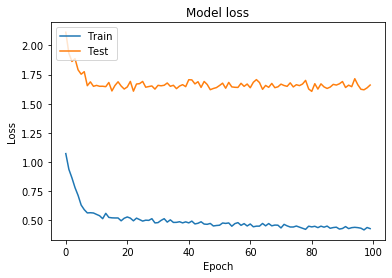

In [7]:
utils.plot_history(hist_wdqm_mae_20drop[1], validation_freq=1)

In [234]:
wdqm_model_mae_20drop.load_weights("wdqm_mae_20drop/model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_mae_20drop)

TID2013:
SpearmanrResult(correlation=0.937050406233307, pvalue=0.0)
(0.9389107, 0.0)
LIVE:
SpearmanrResult(correlation=-0.9031325051029306, pvalue=1.60180275750194e-287)
(-0.89640378838943, 8.733057866736302e-277)
HD_AI:
SpearmanrResult(correlation=0.786467985562594, pvalue=3.5199103029760175e-57)
(0.8083686, 1.070850169704803e-62)
CSIQ:
SpearmanrResult(correlation=-0.920950632385989, pvalue=0.0)
(-0.9017593798230653, 5.5374507e-317)
HD_XL:
SpearmanrResult(correlation=0.8391640425827851, pvalue=7.222344351384367e-82)
(0.80044466, 4.2595163843510124e-69)


In [235]:
wdqm_model_mae_20drop.load_weights("wdqm_mae_20drop/best_model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_mae_20drop)

TID2013:
SpearmanrResult(correlation=0.9231576367530442, pvalue=0.0)
(0.9270249, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8987206183271933, pvalue=2.1373779223333185e-280)
(-0.8876604396778329, 6.864040391524254e-264)
HD_AI:
SpearmanrResult(correlation=0.7850074816093345, pvalue=7.784115864173992e-57)
(0.81759083, 3.0834170885568345e-65)
CSIQ:
SpearmanrResult(correlation=-0.9314664413093392, pvalue=0.0)
(-0.9180525643670813, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8484340132963258, pvalue=1.9528363047130806e-85)
(0.8104862, 4.008058555210077e-72)


### WADIQAM - MAE 0.4 DROP

In [5]:
wdqm_model_mae_40drop = models.get_wadiqam_model(is_diqam=False, lr=0.000025, drop_rate=0.4)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [6]:
hist_wdqm_mae_40drop = utils.train_on_generators("wdqm_mae_40drop", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mae_40drop)

Dir created
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 171s 569ms/step - loss: 1.0961 - val_loss: 2.1128
Epoch 2/100
300/300 [==============================] - 137s 456ms/step - loss: 1.0165 - val_loss: 2.1046
Epoch 3/100
300/300 [==============================] - 134s 447ms/step - loss: 0.8992 - val_loss: 1.9939
Epoch 4/100
300/300 [==============================] - 135s 451ms/step - loss: 0.8056 - val_loss: 1.8814
Epoch 5/100
300/300 [==============================] - 136s 453ms/step - loss: 0.7526 - val_loss: 1.7849
Epoch 6/100
300/300 [==============================] - 136s 452ms/step - loss: 0.6849 - val_loss: 1.8109
Epoch 7/100
300/300 [==============================] - 136s 454ms/step - loss: 0.6659 - val_loss: 1.7406
Epoch 8/100
300/300 [==============================] - 136s 453ms/step - loss: 0.6258 - val_loss: 1.6666
Epoch 9/100
300/300 [==============================] - 137s 456ms/step -

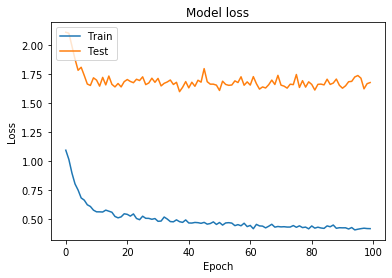

In [7]:
utils.plot_history(hist_wdqm_mae_40drop[1], validation_freq=1)

In [10]:
wdqm_model_mae_40drop.load_weights("wdqm_mae_40drop/model.hdf5")
im_scores_m_40 = evaluate_correlation_metrics(wdqm_model_mae_40drop)

TID2013:
SpearmanrResult(correlation=0.9414617436256076, pvalue=0.0)
(0.944171, 0.0)
LIVE:
SpearmanrResult(correlation=-0.9076611608408686, pvalue=3.3505900020005123e-295)
(-0.90203687099761, 1.0130519168535604e-285)
HD_AI:
SpearmanrResult(correlation=0.774789056133734, pvalue=1.6968585553238254e-54)
(0.8005451, 1.2002232382776094e-60)
CSIQ:
SpearmanrResult(correlation=-0.922951362157268, pvalue=0.0)
(-0.912424963482725, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8631964536266473, pvalue=1.215449131102436e-91)
(0.84722596, 5.875217210953535e-85)


In [11]:
wdqm_model_mae_40drop.load_weights("wdqm_mae_40drop/best_model.hdf5")
im_scores_bm_40 = evaluate_correlation_metrics(wdqm_model_mae_40drop)

TID2013:
SpearmanrResult(correlation=0.9194547714613137, pvalue=0.0)
(0.9211453, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8834739933944306, pvalue=4.338476554446307e-258)
(-0.8686925902606497, 2.9199142053134004e-239)
HD_AI:
SpearmanrResult(correlation=0.8242028795147921, pvalue=3.776863828061477e-67)
(0.84701645, 2.039101005290142e-74)
CSIQ:
SpearmanrResult(correlation=-0.9133065708650128, pvalue=0.0)
(-0.9025661347422465, 1.885522e-318)
HD_XL:
SpearmanrResult(correlation=0.860992747227093, pvalue=1.1381087039669267e-90)
(0.81694, 3.636766091770771e-74)


### WADIQAM - MAE 0.6 DROP

In [12]:
wdqm_model_mae_60drop = models.get_wadiqam_model(is_diqam=False, lr=0.000025, drop_rate=0.6)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [13]:
hist_wdqm_mae_60drop = utils.train_on_generators("wdqm_mae_60drop", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mae_60drop)

Dir created
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 146s 486ms/step - loss: 1.1099 - val_loss: 2.0989
Epoch 2/100
300/300 [==============================] - 138s 460ms/step - loss: 0.9673 - val_loss: 2.1337
Epoch 3/100
300/300 [==============================] - 135s 449ms/step - loss: 0.9016 - val_loss: 1.8796
Epoch 4/100
300/300 [==============================] - 134s 448ms/step - loss: 0.7754 - val_loss: 1.8422
Epoch 5/100
300/300 [==============================] - 135s 449ms/step - loss: 0.7436 - val_loss: 1.7991
Epoch 6/100
300/300 [==============================] - 135s 451ms/step - loss: 0.6953 - val_loss: 1.7916
Epoch 7/100
300/300 [==============================] - 135s 451ms/step - loss: 0.6297 - val_loss: 1.7216
Epoch 8/100
300/300 [==============================] - 135s 451ms/step - loss: 0.6248 - val_loss: 1.6808
Epoch 9/100
300/300 [==============================] - 135s 449ms/step -

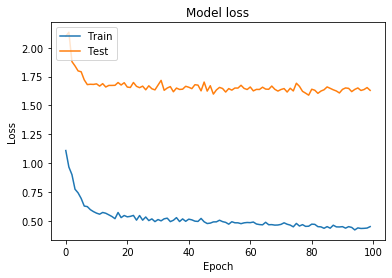

In [14]:
utils.plot_history(hist_wdqm_mae_60drop[1], validation_freq=1)

In [15]:
wdqm_model_mae_60drop.load_weights("wdqm_mae_60drop/model.hdf5")
im_scores_m_60 = evaluate_correlation_metrics(wdqm_model_mae_60drop)

TID2013:
SpearmanrResult(correlation=0.9369046169364278, pvalue=0.0)
(0.93899244, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8978777494965609, pvalue=4.505200371604944e-279)
(-0.8911217132665895, 7.306567540152486e-269)
HD_AI:
SpearmanrResult(correlation=0.7329411534502823, pvalue=4.5273681886550316e-46)
(0.76764125, 6.215207722863633e-53)
CSIQ:
SpearmanrResult(correlation=-0.9111692316127704, pvalue=0.0)
(-0.8934682926752889, 1.3449403778827384e-302)
HD_XL:
SpearmanrResult(correlation=0.8399146073696498, pvalue=3.787065257826402e-82)
(0.8072547, 3.947223939475088e-71)


In [16]:
wdqm_model_mae_60drop.load_weights("wdqm_mae_60drop/best_model.hdf5")
im_scores_bm_60 = evaluate_correlation_metrics(wdqm_model_mae_60drop)

TID2013:
SpearmanrResult(correlation=0.9239811206912353, pvalue=0.0)
(0.93106043, 0.0)
LIVE:
SpearmanrResult(correlation=-0.901887037198276, pvalue=1.7794088494987877e-285)
(-0.8913964986364693, 2.8955717137017052e-269)
HD_AI:
SpearmanrResult(correlation=0.8137739884040056, pvalue=3.611583824037066e-64)
(0.82795376, 2.8611972802305247e-68)
CSIQ:
SpearmanrResult(correlation=-0.9273190238155955, pvalue=0.0)
(-0.9143274012692366, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8698688818342936, pvalue=1.088190042280931e-94)
(0.83378035, 6.735708534224263e-80)


### WADIQAM - MAE 0.8 DROP

In [17]:
wdqm_model_mae_80drop = models.get_wadiqam_model(is_diqam=False, lr=0.000025, drop_rate=0.8)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [18]:
hist_wdqm_mae_80drop = utils.train_on_generators("wdqm_mae_80drop", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mae_80drop)

Dir created
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 163s 544ms/step - loss: 1.1415 - val_loss: 2.0953
Epoch 2/100
300/300 [==============================] - 138s 460ms/step - loss: 0.9633 - val_loss: 1.9756
Epoch 3/100
300/300 [==============================] - 136s 452ms/step - loss: 0.8786 - val_loss: 1.9203
Epoch 4/100
300/300 [==============================] - 137s 456ms/step - loss: 0.7828 - val_loss: 1.8809
Epoch 5/100
300/300 [==============================] - 136s 455ms/step - loss: 0.7336 - val_loss: 1.8142
Epoch 6/100
300/300 [==============================] - 137s 455ms/step - loss: 0.7039 - val_loss: 1.7983
Epoch 7/100
300/300 [==============================] - 137s 456ms/step - loss: 0.6773 - val_loss: 1.7563
Epoch 8/100
300/300 [==============================] - 137s 456ms/step - loss: 0.6459 - val_loss: 1.6886
Epoch 9/100
300/300 [==============================] - 137s 455ms/step -

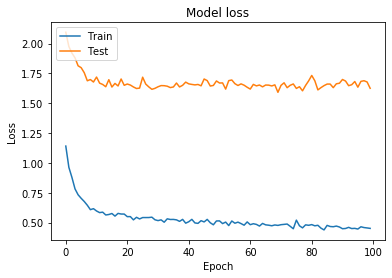

In [19]:
utils.plot_history(hist_wdqm_mae_80drop[1], validation_freq=1)

In [20]:
wdqm_model_mae_80drop.load_weights("wdqm_mae_80drop/model.hdf5")
im_scores_m_80 = evaluate_correlation_metrics(wdqm_model_mae_80drop)

TID2013:
SpearmanrResult(correlation=0.9362199087306236, pvalue=0.0)
(0.9374926, 0.0)
LIVE:
SpearmanrResult(correlation=-0.903233332563335, pvalue=1.0909053459172905e-287)
(-0.8957532097320294, 8.706615851700595e-276)
HD_AI:
SpearmanrResult(correlation=0.7380159263568703, pvalue=5.256388972216746e-47)
(0.78164226, 4.734197776193856e-56)
CSIQ:
SpearmanrResult(correlation=-0.9185684605806637, pvalue=0.0)
(-0.9082457144152805, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8627670769435236, pvalue=1.8851297140551366e-91)
(0.8269258, 1.7234039106545367e-77)


In [21]:
wdqm_model_mae_80drop.load_weights("wdqm_mae_80drop/best_model.hdf5")
im_scores_bm_80 = evaluate_correlation_metrics(wdqm_model_mae_80drop)

TID2013:
SpearmanrResult(correlation=0.9234093044070583, pvalue=0.0)
(0.9246373, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8866835913969706, pvalue=1.6237261039556988e-262)
(-0.8689913455096193, 1.2819490402161248e-239)
HD_AI:
SpearmanrResult(correlation=0.7934200481575748, pvalue=7.377910241021272e-59)
(0.82644296, 8.149713759792765e-68)
CSIQ:
SpearmanrResult(correlation=-0.9087537064060387, pvalue=0.0)
(-0.8856443477892546, 4.488335814932162e-290)
HD_XL:
SpearmanrResult(correlation=0.868893278196569, pvalue=3.1101170689670033e-94)
(0.81698257, 3.5235589930928914e-74)


### WADIQAM - MSE

In [242]:
wdqm_model_mse = models.get_wadiqam_model(is_diqam=False, lr=0.00005, loss_fn=tf.keras.losses.MeanSquaredError())
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [23]:
hist_wdqm_mse = utils.train_on_generators("wadiqam_mse", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mse)

Dir created
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 138s 459ms/step - loss: 2.0242 - val_loss: 6.0238
Epoch 2/100
300/300 [==============================] - 137s 456ms/step - loss: 1.4508 - val_loss: 4.8053
Epoch 3/100
300/300 [==============================] - 137s 457ms/step - loss: 1.0909 - val_loss: 4.4319
Epoch 4/100
300/300 [==============================] - 139s 462ms/step - loss: 0.9257 - val_loss: 4.4266
Epoch 5/100
300/300 [==============================] - 139s 464ms/step - loss: 0.7908 - val_loss: 4.2143
Epoch 6/100
300/300 [==============================] - 139s 464ms/step - loss: 0.7651 - val_loss: 4.1519
Epoch 7/100
300/300 [==============================] - 140s 468ms/step - loss: 0.7728 - val_loss: 3.9741
Epoch 8/100
300/300 [==============================] - 140s 467ms/step - loss: 0.6925 - val_loss: 4.1560
Epoch 9/100
300/300 [==============================] - 138s 460ms/step -

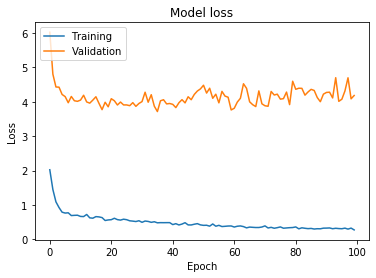

In [4]:
utils.plot_history("wadiqam_mse/history.pkl", validation_freq=1)

In [243]:
wdqm_model_mse.load_weights("wadiqam_mse/model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_mse)

TID2013:
SpearmanrResult(correlation=0.9367894110048285, pvalue=0.0)
(0.92904055, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8955081772542693, pvalue=2.0619493569348382e-275)
(-0.8853876085763611, 1.0325744344303296e-260)
HD_AI:
SpearmanrResult(correlation=0.7980225489342988, pvalue=5.256834461268842e-60)
(0.7899899, 5.059535614763777e-58)
CSIQ:
SpearmanrResult(correlation=-0.9033396757617838, pvalue=7.176e-320)
(-0.8796313072470421, 4.681173973865866e-281)
HD_XL:
SpearmanrResult(correlation=0.8904975475851423, pvalue=2.676497027922882e-105)
(0.86907256, 2.5659225661606463e-94)


In [244]:
wdqm_model_mse.load_weights("wadiqam_mse/best_model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_mse)

TID2013:
SpearmanrResult(correlation=0.9150319906025002, pvalue=0.0)
(0.913483, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8995686148383398, pvalue=9.68653294384035e-282)
(-0.8884711858396888, 4.859103332211855e-265)
HD_AI:
SpearmanrResult(correlation=0.7569753723265316, pvalue=1.0600920405381219e-50)
(0.77961487, 1.3832410201836052e-55)
CSIQ:
SpearmanrResult(correlation=-0.9171262365874918, pvalue=0.0)
(-0.9065917307542946, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8522661467881447, pvalue=5.5611024201028345e-87)
(0.8229037, 3.985725706483203e-76)


### WADIQAM - Correlation

In [245]:
wdqm_model_corr = models.get_wadiqam_model(is_diqam=False, lr=0.000025, loss_fn=utils.correlation_loss)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True, batch_size=10)

In [14]:
hist_wdqm_corr = utils.train_on_generators("wadiqam_corr", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=12, save_freq=10, model=wdqm_model_corr)

Dir exists
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 163s 545ms/step - loss: 0.5360 - val_loss: 0.5873
Epoch 2/100
300/300 [==============================] - 139s 464ms/step - loss: 0.4084 - val_loss: 0.3590
Epoch 3/100
300/300 [==============================] - 137s 457ms/step - loss: 0.3445 - val_loss: 0.3434
Epoch 4/100
300/300 [==============================] - 139s 462ms/step - loss: 0.3312 - val_loss: 0.3430
Epoch 5/100
300/300 [==============================] - 145s 484ms/step - loss: 0.2888 - val_loss: 0.3118
Epoch 6/100
300/300 [==============================] - 139s 464ms/step - loss: 0.2687 - val_loss: 0.3987
Epoch 7/100
300/300 [==============================] - 137s 456ms/step - loss: 0.2719 - val_loss: 0.4030
Epoch 8/100
300/300 [==============================] - 137s 457ms/step - loss: 0.2815 - val_loss: 0.4055
Epoch 9/100
300/300 [==============================] - 135s 452ms/step - 

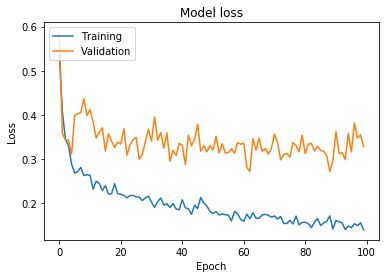

In [5]:
utils.plot_history("wadiqam_corr/history.pkl", validation_freq=1)

In [246]:
wdqm_model_corr.load_weights("wadiqam_corr/model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_corr)

TID2013:
SpearmanrResult(correlation=0.932132385966653, pvalue=0.0)
(0.93681175, 0.0)
LIVE:
SpearmanrResult(correlation=-0.880881367049779, pvalue=1.315318037682472e-254)
(-0.8625544085984207, 4.185691157747474e-232)
HD_AI:
SpearmanrResult(correlation=0.7323821439677356, pvalue=5.7220126256430585e-46)
(0.7683128, 4.455840842141166e-53)
CSIQ:
SpearmanrResult(correlation=-0.9023806981261628, pvalue=4.11116e-318)
(-0.8848435956915177, 7.619860041077005e-289)
HD_XL:
SpearmanrResult(correlation=0.8374712361812884, pvalue=3.060335060886929e-81)
(0.7960505, 7.940304539249074e-68)


In [247]:
wdqm_model_corr.load_weights("wadiqam_corr/best_model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_corr)

TID2013:
SpearmanrResult(correlation=0.9330549105791609, pvalue=0.0)
(0.9365277, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8924052254390148, pvalue=9.478760174306988e-271)
(-0.8719980843150397, 2.884994698185344e-243)
HD_AI:
SpearmanrResult(correlation=0.7629377302721368, pvalue=6.197199067116173e-52)
(0.80592245, 4.792673369622416e-62)
CSIQ:
SpearmanrResult(correlation=-0.9114242685243462, pvalue=0.0)
(-0.8930664792319283, 6.242960494729705e-302)
HD_XL:
SpearmanrResult(correlation=0.852686337800933, pvalue=3.741423141370026e-87)
(0.81179, 1.5730192828535066e-72)


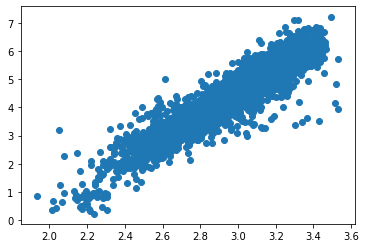

In [18]:
plt.scatter(im_scores_m[0], scores_tid)

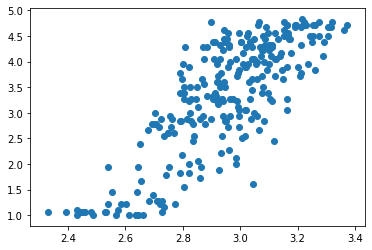

In [19]:
plt.scatter(im_scores_m[2], scores_hdai)

### WADIQAM - 16x16

In [248]:
wdqm_model_16_ps = models.get_wadiqam_model_16(is_diqam=False, lr=0.00005)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=128, patch_size=16)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True, n_patches=256, patch_size=16)

In [29]:
hist_wdqm_16_ps = utils.train_on_generators("wadiqam_16_ps", train_gen, steps_per_epoch=300, epochs=100, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_16_ps)

Dir created
No model was found in model directory.
No history found in model directory.
Epoch 1/100
300/300 [==============================] - 90s 300ms/step - loss: 1.0326 - val_loss: 2.0330
Epoch 2/100
300/300 [==============================] - 86s 288ms/step - loss: 0.7980 - val_loss: 1.8646
Epoch 3/100
300/300 [==============================] - 87s 291ms/step - loss: 0.7356 - val_loss: 1.7121
Epoch 4/100
300/300 [==============================] - 90s 298ms/step - loss: 0.6406 - val_loss: 1.7086
Epoch 5/100
300/300 [==============================] - 87s 289ms/step - loss: 0.6369 - val_loss: 1.6587
Epoch 6/100
300/300 [==============================] - 86s 288ms/step - loss: 0.5920 - val_loss: 1.6489
Epoch 7/100
300/300 [==============================] - 87s 289ms/step - loss: 0.5586 - val_loss: 1.6800
Epoch 8/100
300/300 [==============================] - 87s 289ms/step - loss: 0.5788 - val_loss: 1.6695
Epoch 9/100
300/300 [==============================] - 87s 289ms/step - loss: 0.

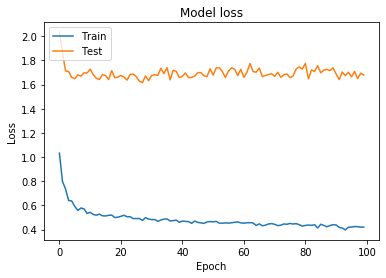

In [30]:
utils.plot_history(hist_wdqm_16_ps[1], validation_freq=1)

In [249]:
wdqm_model_16_ps.load_weights("wadiqam_16_ps/model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_16_ps, 16)

TID2013:
SpearmanrResult(correlation=0.9285832432934663, pvalue=0.0)
(0.9308945, 0.0)
LIVE:
SpearmanrResult(correlation=-0.9023244638845023, pvalue=3.4272755820535477e-286)
(-0.8952545424313545, 5.021940147201544e-275)
HD_AI:
SpearmanrResult(correlation=0.7874372096622422, pvalue=2.0715575396741153e-57)
(0.8072097, 2.183995293458061e-62)
CSIQ:
SpearmanrResult(correlation=-0.9178859026665365, pvalue=0.0)
(-0.9054579864123872, 1e-323)
HD_XL:
SpearmanrResult(correlation=0.8521120633213577, pvalue=6.429017896553305e-87)
(0.8315883, 4.076074279374907e-79)


In [250]:
wdqm_model_16_ps.load_weights("wadiqam_16_ps/best_model.hdf5")
im_scores_m = evaluate_correlation_metrics(wdqm_model_16_ps, 16)

TID2013:
SpearmanrResult(correlation=0.9034566789615117, pvalue=0.0)
(0.908933, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8935979639554522, pvalue=1.5909623728917065e-272)
(-0.8724386130121482, 8.27847236094663e-244)
HD_AI:
SpearmanrResult(correlation=0.7787474045118588, pvalue=2.180857454313363e-55)
(0.80211055, 4.748198348206542e-61)
CSIQ:
SpearmanrResult(correlation=-0.9284741693528056, pvalue=0.0)
(-0.9123910133341895, 0.0)
HD_XL:
SpearmanrResult(correlation=0.859997704147496, pvalue=3.0857493996564325e-90)
(0.81597775, 7.418117761057364e-74)


### WADIQAM - MAE CONV DROP

In [45]:
wdqm_model_mae_ConvDrop = models.get_wadiqam_model(is_diqam=False, lr=0.00005, conv_dropout=True, drop_rate=0.4)
train_gen = utils.tid_batch_generator(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator(hdai_loc, image_split=np.arange(120)*2, endless=True)

In [46]:
hist_wdqm_mae_ConvDrop = utils.train_on_generators("wdqm_mae_ConvDrop", train_gen, steps_per_epoch=300, epochs=150, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_mae_ConvDrop)

Dir exists
No model was found in model directory.
No history found in model directory.
Epoch 1/150
300/300 [==============================] - 197s 656ms/step - loss: 1.1794 - val_loss: 2.1833
Epoch 2/150
300/300 [==============================] - 202s 672ms/step - loss: 1.1431 - val_loss: 2.2161
Epoch 3/150
300/300 [==============================] - 218s 728ms/step - loss: 1.1052 - val_loss: 2.1732
Epoch 4/150
300/300 [==============================] - 220s 734ms/step - loss: 1.1141 - val_loss: 2.1197
Epoch 5/150
300/300 [==============================] - 217s 723ms/step - loss: 1.0089 - val_loss: 2.0249
Epoch 6/150
300/300 [==============================] - 216s 721ms/step - loss: 0.9741 - val_loss: 1.9879
Epoch 7/150
300/300 [==============================] - 216s 721ms/step - loss: 0.9382 - val_loss: 2.0320
Epoch 8/150
300/300 [==============================] - 216s 721ms/step - loss: 0.9091 - val_loss: 1.9868
Epoch 9/150
300/300 [==============================] - 216s 721ms/step - 

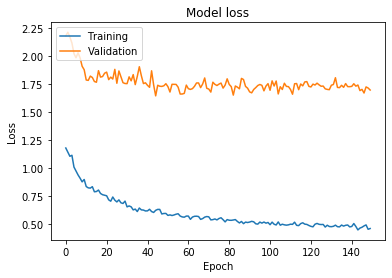

In [47]:
utils.plot_history(hist_wdqm_mae_ConvDrop[1], validation_freq=1)

In [48]:
wdqm_model_mae_ConvDrop.load_weights("wdqm_mae_ConvDrop/model.hdf5")
im_scores_m_cd = evaluate_correlation_metrics(wdqm_model_mae_ConvDrop)

TID2013:
SpearmanrResult(correlation=0.8984435465951178, pvalue=0.0)
(0.90777826, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8987808051118406, pvalue=1.7175299996118028e-280)
(-0.893067311770459, 9.862807251692333e-272)
HD_AI:
SpearmanrResult(correlation=0.5836863126511416, pvalue=1.099773713772526e-25)
(0.6494545, 2.95907764160185e-33)
CSIQ:
SpearmanrResult(correlation=-0.8917988055919736, pvalue=7.610031292238189e-300)
(-0.8862868696291082, 4.5559248786878925e-291)
HD_XL:
SpearmanrResult(correlation=0.8310848274117304, pvalue=6.141016039360958e-79)
(0.826197, 3.0630986095777822e-77)


In [49]:
wdqm_model_mae_ConvDrop.load_weights("wdqm_mae_ConvDrop/best_model.hdf5")
im_scores_bm_cd = evaluate_correlation_metrics(wdqm_model_mae_ConvDrop)

TID2013:
SpearmanrResult(correlation=0.8511867701406942, pvalue=0.0)
(0.86123335, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8653114951681765, pvalue=2.8251925136244833e-235)
(-0.8596615346124525, 7.504053925779257e-229)
HD_AI:
SpearmanrResult(correlation=0.6081136663342112, pvalue=2.722376996081501e-28)
(0.6824658, 8.242242489142837e-38)
CSIQ:
SpearmanrResult(correlation=-0.8455494144274441, pvalue=1.0705359052178653e-237)
(-0.82733674527346, 1.2349259356481284e-218)
HD_XL:
SpearmanrResult(correlation=0.856207653843028, pvalue=1.285852170842731e-88)
(0.82530963, 6.1478669455971796e-77)


### MS-WADIQAM

In [55]:
wdqm_model_ms = models.get_wadiqam_model_ms(is_diqam=False, lr=0.00001)
train_gen = utils.tid_batch_generator_ms(tid_loc, ref_images_tid, scores_tid, image_names_tid, True, n_patches=64)
valid_gen = utils.hdai_batch_generator_ms(hdai_loc, image_split=np.arange(120)*2, endless=True, n_patches=128)

In [56]:
hist_wdqm_ms = utils.train_on_generators("wadiqam_ms", train_gen, steps_per_epoch=300, epochs=150, val_gen=valid_gen,
                           val_steps=120, save_freq=10, model=wdqm_model_ms)

Dir exists
No model was found in model directory.
No history found in model directory.
Epoch 1/150
300/300 [==============================] - 218s 725ms/step - loss: 0.9905 - val_loss: 2.1360
Epoch 2/150
300/300 [==============================] - 213s 710ms/step - loss: 0.8984 - val_loss: 2.1534
Epoch 3/150
300/300 [==============================] - 214s 715ms/step - loss: 0.8454 - val_loss: 2.1085
Epoch 4/150
300/300 [==============================] - 213s 711ms/step - loss: 0.7854 - val_loss: 2.0022
Epoch 5/150
300/300 [==============================] - 214s 713ms/step - loss: 0.7396 - val_loss: 1.9707
Epoch 6/150
300/300 [==============================] - 214s 713ms/step - loss: 0.6863 - val_loss: 1.9117
Epoch 7/150
300/300 [==============================] - 213s 712ms/step - loss: 0.6286 - val_loss: 1.8946
Epoch 8/150
300/300 [==============================] - 214s 712ms/step - loss: 0.5872 - val_loss: 1.8281
Epoch 9/150
300/300 [==============================] - 214s 712ms/step - 

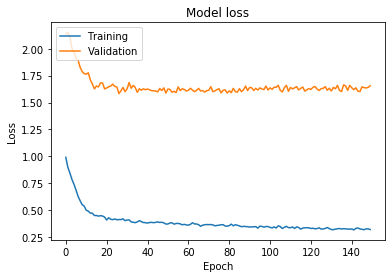

In [57]:
utils.plot_history(hist_wdqm_ms[1], validation_freq=1)

In [58]:
wdqm_model_ms.load_weights("wadiqam_ms/model.hdf5")
im_scores_m = evaluate_correlation_metrics_ms(wdqm_model_ms)

TID2013:
SpearmanrResult(correlation=0.9406138036495615, pvalue=0.0)
(0.9462958, 0.0)
LIVE:
SpearmanrResult(correlation=-0.901400395576439, pvalue=1.1018789360939794e-284)
(-0.892875376322187, 1.90352845674265e-271)
HD_AI:
SpearmanrResult(correlation=0.8041993964396783, pvalue=1.3598331120821066e-61)
(0.817285, 3.763407779552538e-65)
CSIQ:
SpearmanrResult(correlation=-0.8953124770049705, pvalue=1.0818847433871153e-305)
(-0.8813142354810104, 1.5696079620535655e-283)
HD_XL:
SpearmanrResult(correlation=0.8364664384025942, pvalue=7.154694210077578e-81)
(0.8104328, 4.1639509372844144e-72)


In [59]:
wdqm_model_ms.load_weights("wadiqam_ms/best_model.hdf5")
im_scores_m = evaluate_correlation_metrics_ms(wdqm_model_ms)

TID2013:
SpearmanrResult(correlation=0.910117394803536, pvalue=0.0)
(0.915731, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8927512874412697, pvalue=2.9099647344998527e-271)
(-0.8647707128517147, 1.1980478101861195e-234)
HD_AI:
SpearmanrResult(correlation=0.7830424979062809, pvalue=2.242424313632503e-56)
(0.8109611, 2.1361591017773938e-63)
CSIQ:
SpearmanrResult(correlation=-0.909980847026076, pvalue=0.0)
(-0.8903657679836264, 1.6158906640942493e-297)
HD_XL:
SpearmanrResult(correlation=0.8906304193746464, pvalue=2.251590076943263e-105)
(0.8431614, 2.2312624809098802e-83)


### Bagging

In [70]:
def evaluate_aggregation(scores_list):
    results = []
    for i in range(5):
        acc = np.zeros((len(scores_list[0][i]),))
        for j in range(len(scores_list)):
            acc += scores_list[j][i]
        results.append(acc / len(scores_list))
    agg = np.array(results)
        
    print("TID2013:")
    print(scipy.stats.spearmanr(agg[0], scores_tid))
    print(scipy.stats.pearsonr(agg[0], scores_tid))
    print("LIVE:")
    print(scipy.stats.spearmanr(agg[1], non_orgs_scores_live))
    print(scipy.stats.pearsonr(agg[1], non_orgs_scores_live))
    print("HD_AI:")
    print(scipy.stats.spearmanr(agg[2], scores_hdai))
    print(scipy.stats.pearsonr(agg[2], scores_hdai))
    print("CSIQ:")
    print(scipy.stats.spearmanr(agg[3], scores_csiq))
    print(scipy.stats.pearsonr(agg[3], scores_csiq))
    print("HD_XL:")
    print(scipy.stats.spearmanr(agg[4], scores_hdxl))
    print(scipy.stats.pearsonr(agg[4], scores_hdxl))

In [71]:
evaluate_aggregation([im_scores_m, im_scores_bm_wdqm])

TID2013:
SpearmanrResult(correlation=0.936610541895044, pvalue=0.0)
(0.9422110004815395, 0.0)
LIVE:
SpearmanrResult(correlation=-0.8997954004705789, pvalue=4.214769987090051e-282)
(-0.8854797702055357, 7.698319501602118e-261)
HD_AI:
SpearmanrResult(correlation=0.8061933988894016, pvalue=4.06391226274639e-62)
(0.8287193177349206, 1.676855099069057e-68)
CSIQ:
SpearmanrResult(correlation=-0.9201620769785968, pvalue=0.0)
(-0.9052214789003008, 2.5e-323)
HD_XL:
SpearmanrResult(correlation=0.8777593726524725, pvalue=1.6104928242484042e-98)
(0.8437799089339224, 1.2915539002868181e-83)


In [72]:
evaluate_aggregation([im_scores_m, im_scores_bm_wdqm, im_scores_bm_60])

TID2013:
SpearmanrResult(correlation=0.9387532750698081, pvalue=0.0)
(0.9447213054367641, 0.0)
LIVE:
SpearmanrResult(correlation=-0.9028477411425032, pvalue=4.729016408466506e-287)
(-0.8909202822526248, 1.4377997079580822e-268)
HD_AI:
SpearmanrResult(correlation=0.8129480702295641, pvalue=6.105311354725506e-64)
(0.8319403446853524, 1.7194296135953456e-69)
CSIQ:
SpearmanrResult(correlation=-0.9249307881096069, pvalue=0.0)
(-0.9117091518146749, 0.0)
HD_XL:
SpearmanrResult(correlation=0.879961370090104, pvalue=1.2321436601438196e-99)
(0.8453210261037019, 3.2731937311906695e-84)


In [73]:
evaluate_aggregation([im_scores_m, im_scores_bm_60, im_scores_bm_40, im_scores_bm_wdqm])

TID2013:
SpearmanrResult(correlation=0.9406556357160618, pvalue=0.0)
(0.9462174963157068, 0.0)
LIVE:
SpearmanrResult(correlation=-0.899607986286247, pvalue=8.38474661019424e-282)
(-0.8871963832817553, 3.0963921462199455e-263)
HD_AI:
SpearmanrResult(correlation=0.8220449689794845, pvalue=1.621089951410895e-66)
(0.8396626700925022, 5.969759321179113e-72)
CSIQ:
SpearmanrResult(correlation=-0.923960669842879, pvalue=0.0)
(-0.9117551297007085, 0.0)
HD_XL:
SpearmanrResult(correlation=0.8794595761454983, pvalue=2.223130531968962e-99)
(0.8415813768711085, 8.922035360285489e-83)


## Training Generators